In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from openslide import OpenSlide
import h5py
from omegaconf import OmegaConf
from maskWSI_fp import MaskWSI_fp
from matplotlib import patches
from PIL import Image
import json
from shapely import Polygon
from shapely.plotting import plot_polygon
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Polygon
from rtree import index
from collections import Counter
from tqdm import tqdm

In [2]:
conf_preproc = OmegaConf.load("../../conf/preproc.yaml")
conf_preproc = conf_preproc["project_mil"]

In [ ]:
DATA_ROOT = conf_preproc.slides_root_dir
DATA_ROOT

In [4]:
slides = np.sort(np.array( glob.glob( os.path.join(DATA_ROOT, "*.mrxs")) ))

In [ ]:
slides.shape, slides[:15]

In [ ]:
slides[13]

In [ ]:
wsi = OpenSlide(slides[13])
wsi.get_thumbnail((512,512))

In [8]:
wsi.dimensions

(272128, 294144)

In [9]:
wsi.level_count

10

In [10]:
wsi.level_dimensions

((272128, 294144),
 (136064, 147072),
 (68032, 73536),
 (34016, 36768),
 (17008, 18384),
 (8504, 9192),
 (4252, 4596),
 (2126, 2298),
 (1063, 1149),
 (531, 574))

In [11]:
mask_level = 6 if wsi.level_count-1 >= 6 else wsi.level_count-3

In [12]:
mask_level

6

In [13]:
wsi.properties;

In [14]:
float(wsi.properties["openslide.mpp-x"]), float(wsi.properties["openslide.mpp-y"])

(0.242534722222222, 0.242647058823529)

### Number of regions in the SOTE cohort

WSIs: 329
patients: 286

### WSI

In [15]:
biopsy_df = pd.read_csv("../../biopsy_df.csv")
labels_df = pd.read_csv("../../labels_df.csv")
biopsy_df.shape, labels_df.shape

((286, 17), (329, 18))

In [ ]:
biopsy_df.head(5)

In [ ]:
labels_df.head(5)

In [18]:
labels_df.base_slide_number.nunique()

286

In [19]:
def load_h5_file(filename):
    with h5py.File(filename, "r") as f:
        coords = f['coords'][()]
        patch_level = f['coords'].attrs['patch_level']
        patch_size = f['coords'].attrs['patch_size']
        return coords, patch_level, patch_size

In [ ]:
slides[13], slides.shape

In [21]:
coords, patch_level, patch_size = load_h5_file(conf_preproc.mask_save_dir + "1.h5")

In [22]:
coords.shape, patch_level, patch_size

((165, 2), 4, 224)

In [23]:
num_regions = []

for i in tqdm(range(labels_df.shape[0])):

    coords, _, _ = load_h5_file(conf_preproc.mask_save_dir + labels_df.slide_id[i])

    num_regions.append(coords.shape[0])

num_regions = np.array(num_regions)

100%|██████████| 329/329 [00:01<00:00, 189.28it/s]


In [24]:
print("Number of 224x224 regions:", num_regions.sum())

Number of 224x224 regions: 122507


In [25]:
num_regions.mean()

372.36170212765956

In [26]:
 np.percentile(num_regions, [25, 50, 75])

array([288., 371., 444.])

### Patients

In [27]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [28]:
embeddings, coords, slides, labels = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs + "3.h5")

In [29]:
embeddings.shape

(476, 1024)

In [30]:
biopsy_bags = np.sort(np.array( glob.glob( os.path.join(conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs, "*.h5")) ))

In [31]:
biopsy_bags.shape

(286,)

In [32]:
num_regions_patients = []

for i in tqdm(range(biopsy_bags.shape[0])):

    embeddings, _, _, _ = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs + os.path.basename(biopsy_bags[i]))

    num_regions_patients.append(embeddings.shape[0])

num_regions_patients = np.array(num_regions_patients)

100%|██████████| 286/286 [00:03<00:00, 89.63it/s] 


In [33]:
num_regions_patients.sum()

122507

In [34]:
num_regions_patients.mean()

428.34615384615387

In [35]:
 np.percentile(num_regions_patients, [25, 50, 75])

array([298.25, 380.  , 496.5 ])

### Summary table

In [36]:
# 1) Attach patch counts to each WSI row
labels_sem = labels_df.copy()
assert len(num_regions) == len(labels_sem), "num_regions length must match labels_df rows"
labels_sem["n_patches_wsi"] = np.asarray(num_regions).astype(int)

# 2) Helper to compute median [IQR] and min–max
def median_iqr_minmax(x):
    x = np.asarray(x)
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    return {
        "median": float(med),
        "q1": float(q1),
        "q3": float(q3),
        "min": int(np.min(x)),
        "max": int(np.max(x)),
        "median_iqr_str": f"{med:.0f} [{q1:.0f}, {q3:.0f}]",
        "minmax_str": f"{int(np.min(x))}–{int(np.max(x))}",
    }

# -----------------------------
# A) PATCHES PER WSI
# -----------------------------
wsi_stats = median_iqr_minmax(labels_sem["n_patches_wsi"].values)

# -----------------------------
# B/C) PATIENT-LEVEL AGGREGATION
# patient_id = base_slide_number
# - patches per patient: sum across that patient's WSIs
# - WSIs per patient: count
# -----------------------------
per_patient = (
    labels_sem
    .groupby("base_slide_number", as_index=False)
    .agg(
        n_patches_patient=("n_patches_wsi", "sum"),
        n_wsis=("slide_id", "count"),
    )
)

patient_patch_stats = median_iqr_minmax(per_patient["n_patches_patient"].values)
wsis_per_patient_stats = median_iqr_minmax(per_patient["n_wsis"].values)

# -----------------------------
# D) TOTALS
# -----------------------------
total_patches = int(labels_sem["n_patches_wsi"].sum())
n_wsis = int(labels_sem["slide_id"].nunique())
n_patients = int(labels_sem["base_slide_number"].nunique())

# 3) Final 1-row cohort summary table (Semmelweis)
summary_sem = pd.DataFrame([{
    "Cohort": "Semmelweis",
    "Patients (n)": n_patients,
    "WSIs (n)": n_wsis,
    "WSIs/patient, median [IQR]": wsis_per_patient_stats["median_iqr_str"],
    "WSIs/patient, min–max": wsis_per_patient_stats["minmax_str"],
    "Patches/WSI, median [IQR]": wsi_stats["median_iqr_str"],
    "Patches/WSI, min–max": wsi_stats["minmax_str"],
    "Patches/patient, median [IQR]": patient_patch_stats["median_iqr_str"],
    "Patches/patient, min–max": patient_patch_stats["minmax_str"],
    "Total patches (2.5x)": total_patches,
}])

summary_sem


,Cohort,Patients (n),WSIs (n),"WSIs/patient, median [IQR]","WSIs/patient, min–max","Patches/WSI, median [IQR]","Patches/WSI, min–max","Patches/patient, median [IQR]","Patches/patient, min–max",Total patches (2.5x)
0,Semmelweis,286,329,"1 [1, 1]",1–4,"371 [288, 444]",103–777,"380 [298, 496]",103–2128,122507


In [37]:
summary_sem.to_csv("summary_sem.csv", index=False)

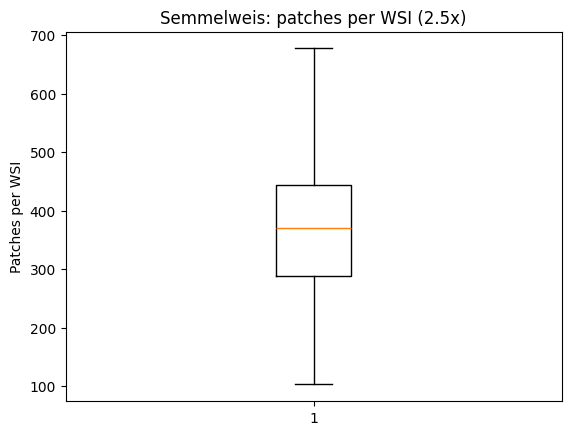

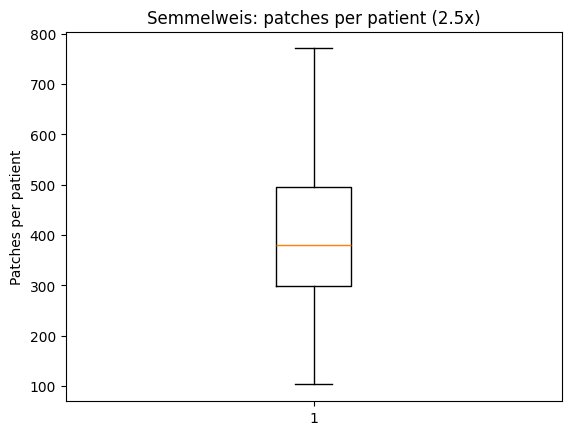

In [38]:
plt.figure()
plt.boxplot(labels_sem["n_patches_wsi"].values, showfliers=False)
plt.ylabel("Patches per WSI")
plt.title("Semmelweis: patches per WSI (2.5x)")
plt.show()

plt.figure()
plt.boxplot(per_patient["n_patches_patient"].values, showfliers=False)
plt.ylabel("Patches per patient")
plt.title("Semmelweis: patches per patient (2.5x)")
plt.show()


### Summary table all cohorts

In [2]:
summary_sem = pd.read_csv("summary_sem.csv")
summary_ng = pd.read_csv("summary_ng.csv")
summary_tcga_brca = pd.read_csv("summary_tcga_brca.csv")

summary_all = pd.concat([summary_sem, summary_ng, summary_tcga_brca], ignore_index=True)
summary_all

,Cohort,Patients (n),WSIs (n),"WSIs/patient, median [IQR]","WSIs/patient, min–max","Patches/WSI, median [IQR]","Patches/WSI, min–max","Patches/patient, median [IQR]","Patches/patient, min–max",Total patches (2.5x)
0,Semmelweis,286,329,"1 [1, 1]",1–4,"371 [288, 444]",103–777,"380 [298, 496]",103–2128,122507
1,Nightingale,574,9489,"11 [5, 24]",1–110,"193 [100, 312]",1–819,"1228 [458, 5812]",46–28286,2058794
2,TCGA-BRCA,678,731,"1 [1, 1]",1–3,"225 [92, 334]",1–628,"234 [100, 349]",1–929,163782
